In [0]:
from config import *
from glob import glob
from src.model import *
from src.camvid_pipeline import *
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

In [2]:
batch_size = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
train_images = sorted(glob('./CamVid/train/*'))
train_labels = sorted(glob('./CamVid/trainannot/*'))
val_images = sorted(glob('./CamVid/val/*'))
val_labels = sorted(glob('./CamVid/valannot/*'))
test_images = sorted(glob('./CamVid/test/*'))
test_labels = sorted(glob('./CamVid/testannot/*'))

In [0]:
train_dataset = CamVidDataset(train_images, train_labels, 512, 512)
val_dataset = CamVidDataset(val_images, val_labels, 512, 512)
test_dataset = CamVidDataset(test_images, test_labels, 512, 512)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [6]:
enet = Enet(12, encoder_relu=True, decoder_relu=True)
enet = enet.to(device)
print(enet)

Enet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (secondary_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down_bottleneck_1): DownsampleBottleneckBlock(
    (main_conv_block_1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (main_conv_block_2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (main_conv_block_3): Sequential(
      (0): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNor

In [7]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([10, 3, 512, 512]), torch.Size([10, 512, 512]))

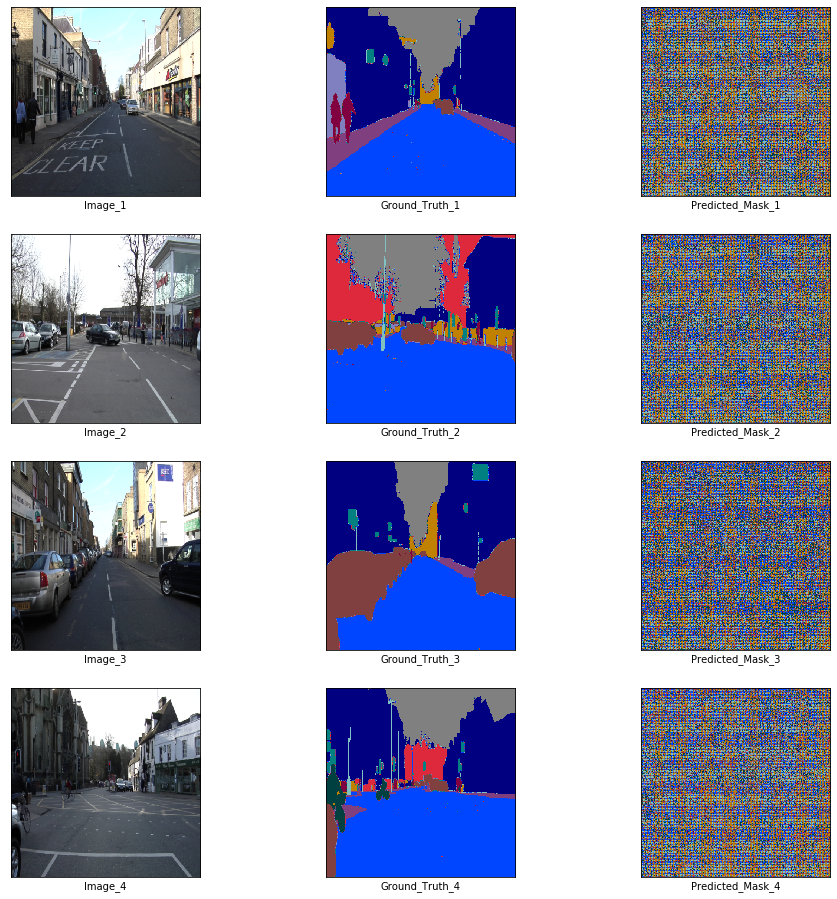

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

In [0]:
class_weights = get_class_weights(train_loader, 12)
criterion = CrossEntropyLoss(
    weight=torch.FloatTensor(class_weights).to(device)
)
optimizer = Adam(
    enet.parameters(),
    lr=5e-4,
    weight_decay=2e-4
)

In [10]:
train_loss_history, val_loss_history = train(
    enet, train_loader, val_loader,
    device, criterion, optimizer,
    len(train_images) // batch_size,
    len(val_images) // batch_size, 5,
    './checkpoints/', 'enet-model', 100
)

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 2.4598285820749073


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 7.901410102844238
Epoch 2



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 2.152319696214464


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 3.0175647735595703
Epoch 3



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.8869699670208826


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 4.347776889801025
Epoch 4



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.7352891332573361


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 10.133393287658691
Epoch 5



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.6253636015786066


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 11.105162620544434
Epoch 6



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.5266980462604098


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 4.190064430236816
Epoch 7



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.4889345732000139


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 6.064733505249023
Epoch 8



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.3956619501113892


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 6.014584541320801
Epoch 9



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.38000778026051


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 4.4311747550964355
Epoch 10



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.346857809358173


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 2.7014882564544678
Epoch 11



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.276411642630895


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 1.1578861474990845
Epoch 12



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.2452717522780101


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 3.121023416519165
Epoch 13



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.2128172152572207


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 4.150857448577881
Epoch 14



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.1889433364073436


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: 2.0183610916137695
Epoch 15



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.1438329567511876


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.9682364463806152
Epoch 16



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.0974112119939592


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.9853577613830566
Epoch 17



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.0804198698865042


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -7.455694198608398
Epoch 18



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.0710441304577722


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.949195861816406
Epoch 19



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.025514394044876


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -8.704667091369629
Epoch 20



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9854134602679147


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -7.083247184753418
Epoch 21



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9767175300253762


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -8.361712455749512
Epoch 22



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9649885694185892


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -10.207038879394531
Epoch 23



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9625357886155447


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -6.151366233825684
Epoch 24



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9152677059173584


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -5.8832268714904785
Epoch 25



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9058049552970462


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.33828592300415
Epoch 26



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.9341878725422753


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -8.623285293579102
Epoch 27



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8941407435470157


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -5.108339786529541
Epoch 28



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8808111647764841


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.697124004364014
Epoch 29



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8634372270769544


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -5.8382110595703125
Epoch 30



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8566450228293737


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.46821403503418
Epoch 31



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.852885494629542


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.9980766773223877
Epoch 32



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8357250210311677


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.352340221405029
Epoch 33



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.830469987458653


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.2658960819244385
Epoch 34



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8313266568713717


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.460041046142578
Epoch 35



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8396516508526273


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -5.2331647872924805
Epoch 36



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8413629531860352


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.8184986114501953
Epoch 37



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.8109182599518034


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.9878838062286377
Epoch 38



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7819201532337401


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.9306747913360596
Epoch 39



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7893209225601621


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -0.9866714477539062
Epoch 40



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7856955710384581


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.7095203399658203
Epoch 41



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7605978267060386


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.964995265007019
Epoch 42



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7550962120294571


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.3755924701690674
Epoch 43



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7500247591071658


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.8830559253692627
Epoch 44



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7538865274853177


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.7347289323806763
Epoch 45



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7322584125730727


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.8358829021453857
Epoch 46



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7057236681381861


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.25078821182251
Epoch 47



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7164157778024673


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.1355364322662354
Epoch 48



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7111727181408141


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.2835614681243896
Epoch 49



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6976552903652191


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.7588160037994385
Epoch 50



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7222454912132688


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.4129456281661987
Epoch 51



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7090404116445117


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.360605239868164
Epoch 52



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6984603189759784


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.6243386268615723
Epoch 53



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6906961053609848


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.643939733505249
Epoch 54



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.7075764338175455


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.7359731197357178
Epoch 55



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6879824731085036


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.9939095973968506
Epoch 56



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6611097322569953


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.562823534011841
Epoch 57



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6450340863731172


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.5238382816314697
Epoch 58



 44%|████▍     | 16/36 [00:42<00:54,  2.73s/it]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lkf4g0id'
  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6679136008024216


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.540314197540283
Epoch 59



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6494954824447632


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.3125431537628174
Epoch 60



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6483558532264497


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.1592442989349365
Epoch 61



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6349105851517783


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -4.374671459197998
Epoch 62



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6511844793955485


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.776857852935791
Epoch 63



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6383056938648224


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.723688840866089
Epoch 64



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6240225351519055


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.360243082046509
Epoch 65



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6095739478866259


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.8267111778259277
Epoch 66



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6088566109538078


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.6731761693954468
Epoch 67



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6204385219348801


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.45924973487854
Epoch 68



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6236076768901613


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.814703941345215
Epoch 69



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6015593782067299


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.477762222290039
Epoch 70



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5941943493154314


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.1101138591766357
Epoch 71



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6031844218571981


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.042449951171875
Epoch 72



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.6260783357752694


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.896686315536499
Epoch 73



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.592480882174439


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.3903305530548096
Epoch 74



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5970628402299352


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.726210355758667
Epoch 75



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5881621787945429


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.759636640548706
Epoch 76



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5785039936502775


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.941937804222107
Epoch 77



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5658397451043129


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.973731279373169
Epoch 78



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5613967726627985


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.9385956525802612
Epoch 79



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5803780381878217


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.368589162826538
Epoch 80



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5737429741356108


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.694733738899231
Epoch 81



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5605198070406914


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.1572012901306152
Epoch 82



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5747581976983283


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.582575559616089
Epoch 83



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5518559921118948


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.184271812438965
Epoch 84



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5572914092077149


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.3055992126464844
Epoch 85



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5583200827240944


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.192243814468384
Epoch 86



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.576850506166617


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.0931477546691895
Epoch 87



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5479975442091624


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -1.6419821977615356
Epoch 88



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5385823084248437


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.138461112976074
Epoch 89



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5398485337694486


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.0832982063293457
Epoch 90



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5475111785862181


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.650509834289551
Epoch 91



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.544412460592058


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.4123969078063965
Epoch 92



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5461062118411064


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.41131591796875
Epoch 93



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5173569214012887


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.4824953079223633
Epoch 94



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5270656206541591


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.3794493675231934
Epoch 95



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5334247739778625


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.8035075664520264
Epoch 96



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5330682016081281


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.489121913909912
Epoch 97



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5216312805811564


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.656475782394409
Epoch 98



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5124557904071279


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -3.0291895866394043
Epoch 99



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5192588824364874


  0%|          | 0/36 [00:00<?, ?it/s]


Validation Loss: -2.4304022789001465
Epoch 100



  0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.5132700312468741


100%|██████████| 10/10 [00:23<00:00,  2.45s/it]


Validation Loss: -2.574481725692749

Training Done.
Training Mean Loss: 0.826446
Validation Mean Loss: -2.323322


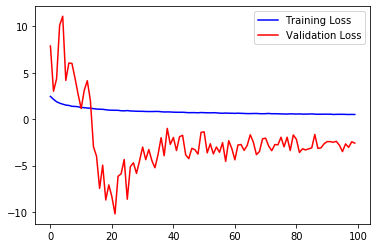

In [11]:
plt.plot(train_loss_history, color = 'b', label = 'Training Loss')
plt.plot(val_loss_history, color = 'r', label = 'Validation Loss')
plt.legend()
plt.show()

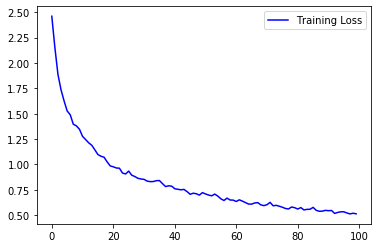

In [12]:
plt.plot(train_loss_history, color = 'b', label = 'Training Loss')
plt.legend()
plt.show()

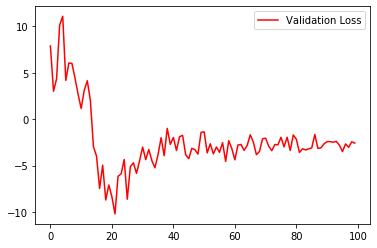

In [13]:
plt.plot(val_loss_history, color = 'r', label = 'Validation Loss')
plt.legend()
plt.show()

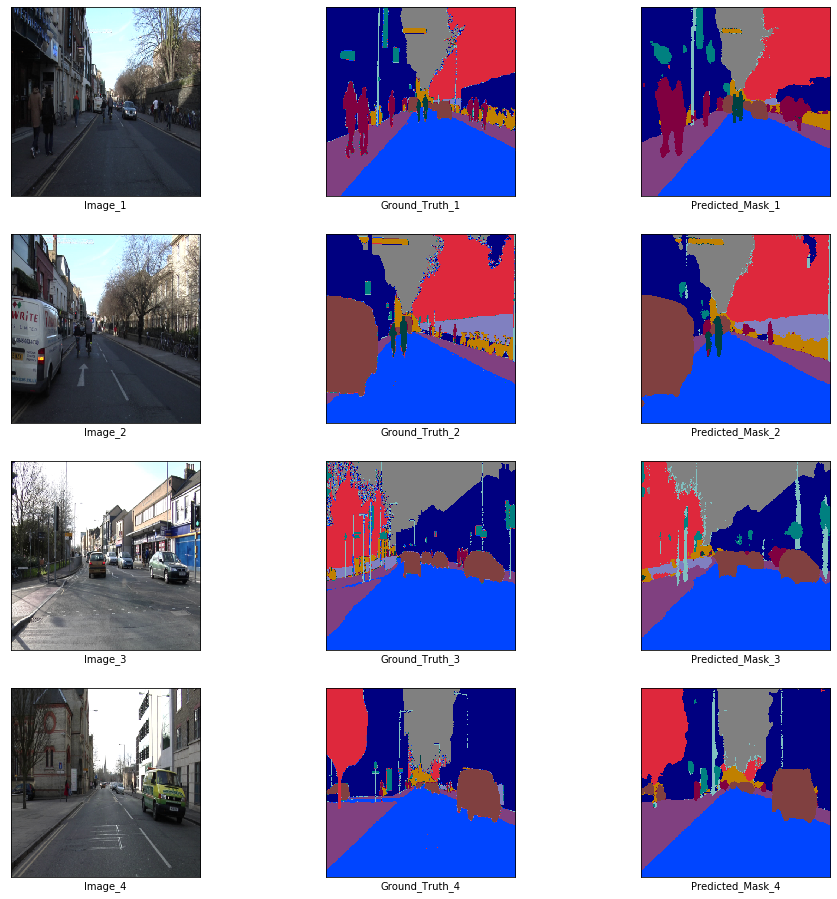

In [14]:
x_batch, y_batch = next(iter(train_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

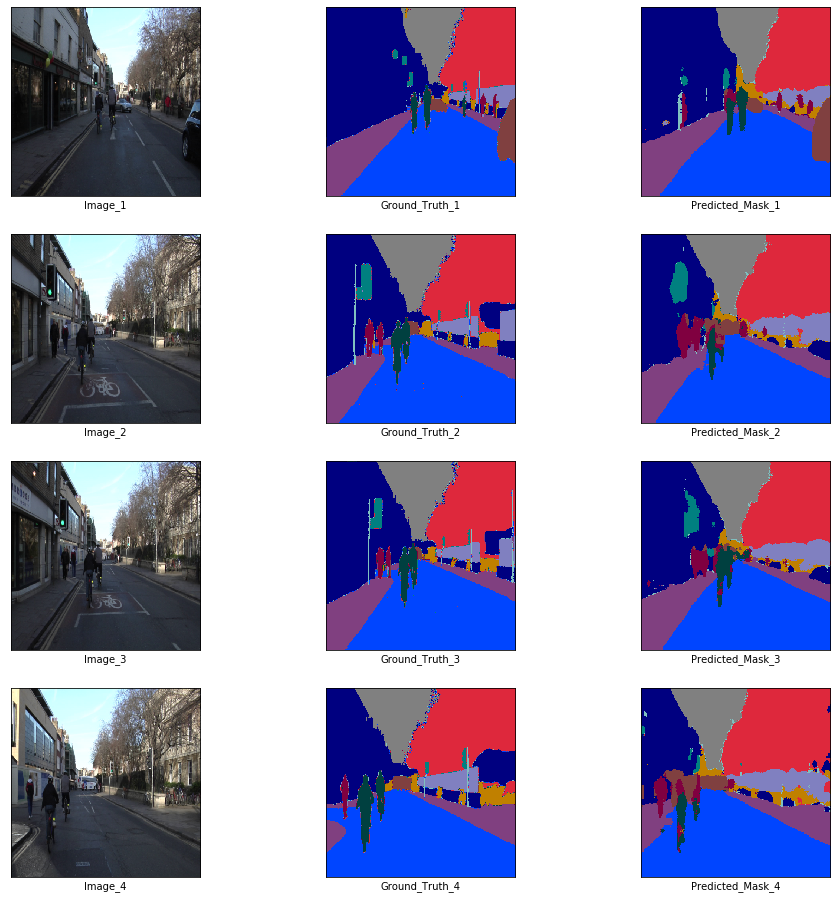

In [15]:
x_batch, y_batch = next(iter(val_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()